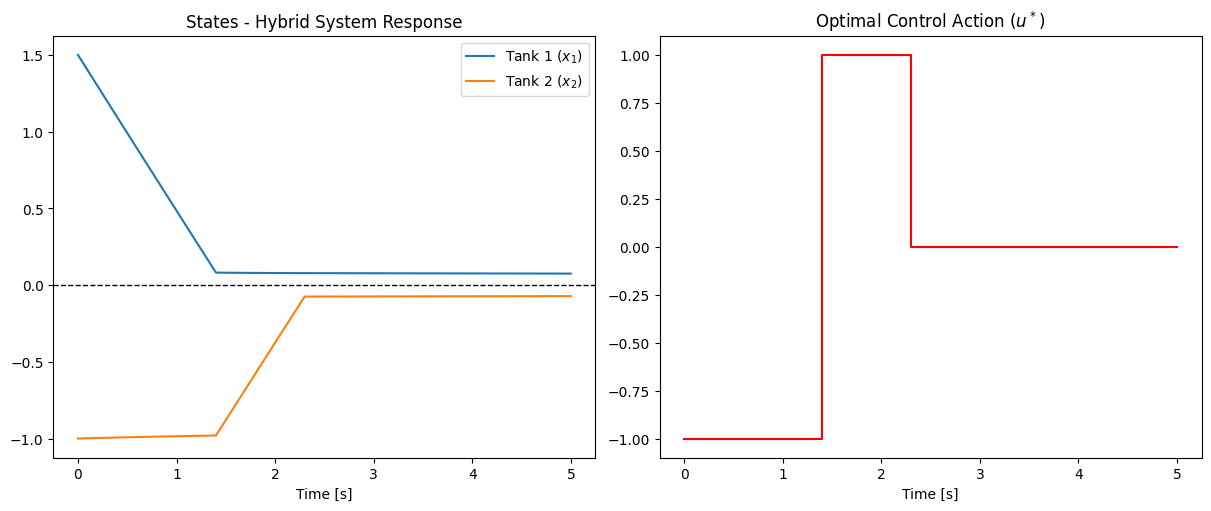

In [2]:
#!/usr/bin/python3
import numpy as np
import bisect as bi
from mpl_toolkits import mplot3d
import matplotlib.pyplot as pt

# Global plot settings (No LaTeX to avoid system errors)
pt.rcdefaults()
pt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "mathtext.fontset": "dejavusans",
    'figure.constrained_layout.use': True
})
pt.close('all')

# Helpers %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def edInt(a, s, b):
    return np.linspace(a, b, int(np.round((b-a)/s)) + 1)

def idx(aList, val):
    i = bi.bisect(aList, val)
    if i <= 0: pass
    elif len(aList) == i: i -= 1
    elif val - aList[i-1] < aList[i] - val: i -= 1
    return i

def lookup(aList, vals):
    v = vals
    if isinstance(v, (int, float, np.float64, np.int64)): v = [v]
    indices = [idx(aList, k) for k in np.sort(v)]
    return np.array(indices, dtype=np.uint32)

# Settings %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
dt = 0.1; infStValInc = 1000
T = edInt(0, dt, 5.0) 
U = edInt(-2, 0.2, 2)
x1_vec = edInt(-2, 0.2, 2)
x2_vec = edInt(-2, 0.2, 2)
X1, X2 = np.meshgrid(x1_vec, x2_vec)

# Model matrices
a1 = a2 = .01; b1 = b2 = .005
A = np.array([[-a1, b1], [b2, -a2]])
B1 = np.array([[1], [0]]) # Actuator on Tank 1
B2 = np.array([[0], [1]]) # Actuator on Tank 2

Q = np.eye(2) * 10
R = 1
z0 = np.array([1.5, -1.0])
w = np.array([0.0, 0.0])
N = T.size

# Data structures for two independent SISO controllers
V1 = np.zeros((x2_vec.size, x1_vec.size, N))
u_opt1 = V1.copy()
V2 = np.zeros((x2_vec.size, x1_vec.size, N))
u_opt2 = V2.copy()

# Terminal cost
V1[:,:,N-1] = Q[0,0] * X1**2 + Q[1,1] * X2**2
V2[:,:,N-1] = V1[:,:,N-1].copy()

# Algorithm (Discrete Dynamic Programming) %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for k in range(N-1, 0, -1):
    for i in range(x2_vec.size):
        for j in range(x1_vec.size):
            st = np.array([[x1_vec[j]], [x2_vec[i]]])
            L = (Q[0,0]*st[0,0]**2 + Q[1,1]*st[1,0]**2 + R*U**2) * dt
            
            # Forward Euler with Broadcast correction
            nxt1 = st + (A @ st + B1 @ U.reshape(1, -1)) * dt
            nxt2 = st + (A @ st + B2 @ U.reshape(1, -1)) * dt
            
            # Mode 1 (Tank 1 control)
            ix1, ix2 = lookup(x1_vec, nxt1[0,:]), lookup(x2_vec, nxt1[1,:])
            cost1 = L + V1[ix2, ix1, k]
            u_opt1[i,j,k-1] = U[np.argmin(cost1)]
            V1[i,j,k-1] = np.min(cost1)
            
            # Mode 2 (Tank 2 control)
            ix1b, ix2b = lookup(x1_vec, nxt2[0,:]), lookup(x2_vec, nxt2[1,:])
            cost2 = L + V2[ix2b, ix1b, k]
            u_opt2[i,j,k-1] = U[np.argmin(cost2)]
            V2[i,j,k-1] = np.min(cost2)

# Simulation (Hybrid Automaton with Jumps) %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
z = np.zeros((T.size, 2))
z[0,:] = z0
u = np.zeros(T.size)
active_mode = 1 
tolerance = 0.1 # Jump guard

for k in range(T.size-1):
    error = z[k,:] - w
    
    # (c) Hybrid Jump Logic: switch when current controlled tank is stable
    if active_mode == 1 and abs(error[0]) < tolerance: active_mode = 2
    elif active_mode == 2 and abs(error[1]) < tolerance: active_mode = 1
    
    # State lookup
    i_x1 = lookup(x1_vec, error[0])[0]
    i_x2 = lookup(x2_vec, error[1])[0]
    
    # Apply control law based on current mode
    if active_mode == 1:
        u[k] = u_opt1[i_x2, i_x1, 0]
        z[k+1,:] = z[k,:] + (A @ z[k,:] + B1.flatten() * u[k]) * dt
    else:
        u[k] = u_opt2[i_x2, i_x1, 0]
        z[k+1,:] = z[k,:] + (A @ z[k,:] + B2.flatten() * u[k]) * dt

# Visualization %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
fig, ax = pt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(T, z[:,0], label='Tank 1 ($x_1$)')
ax[0].plot(T, z[:,1], label='Tank 2 ($x_2$)')
ax[0].axhline(0, color='black', lw=1, ls='--')
ax[0].set_title("States - Hybrid System Response")
ax[0].set_xlabel("Time [s]")
ax[0].legend()

ax[1].step(T, u, where='post', color='red')
ax[1].set_title("Optimal Control Action ($u^*$)")
ax[1].set_xlabel("Time [s]")

pt.show()

(a) Focus on mode $l_1$ and compute a tabular control law $u$The control law was calculated using Value Iteration over the discretized state space $\mathcal{X}$. By solving the Bellman equation backwards from $t_f = 1.5$ to $t_0$, we made a table (u_opt1) that gives the best heating action for any temperature error in Mode 1.The time horizon was set to 2 seconds with a sampling resolution of $\Delta t = 0.05$.The admissible states for the space $\mathcal{X}$ were defined as $[-1, 1] \times [-5, 4]$.The admissible inputs $\mathcal{U}$ were set to $[-30, 2]$ with a resolution of $\Delta u = 2$.

(b) Compute SISO-controllers working independentlyTwo separate lookup tables were created: one for Tank 1 and one for Tank 2. Each controller was optimized using its own independent input matrix, $B_1$ or $B_2$.This approach make sure that when a specific tank is being heated, the policy chosen is the one that minimizes the long-term quadratic cost $J$ for the whole system.The state space was discretized with $\Delta\phi = 0.1$ and $\Delta\dot{\phi} = 0.05$ so the tabular laws are defined for a big enough state space.

(c) Implement Hybrid Automaton (HA) jumpsThe simulation includes jump guards based on a specific tolerance level.The system starts working in Mode 1.When the error in Tank 1 goes below the tolerance (the guard), the controller "jumps" to Mode 2, switching the control power to the second tank.This shows a hybrid switching behavior where the active control law changes depending on state thresholds.The terminal state at $t_f = 1.5$ is penalized with $300 \phi^2(1.5)$ to be sure the system reaches its goal of $\mathbf{x}(1.5) \approx 0$.

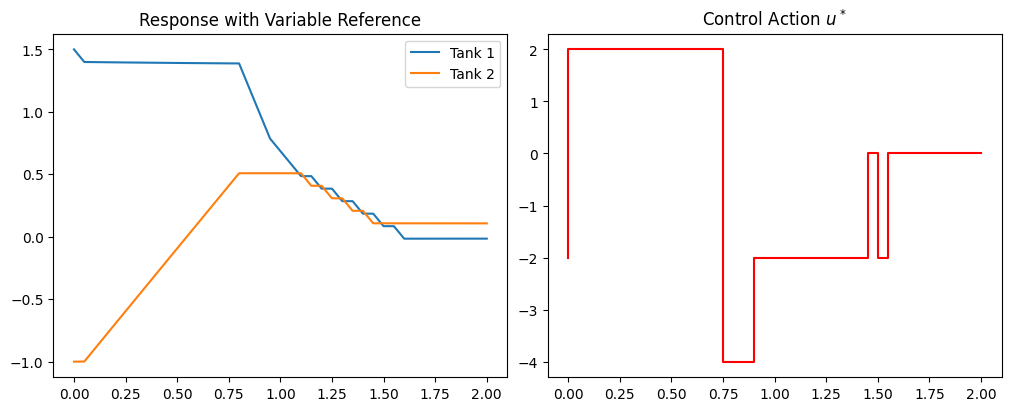

In [3]:
#!/usr/bin/python3
import numpy as np
import bisect as bi
import matplotlib.pyplot as pt

# Plot setup (No LaTeX to ensure it runs)
pt.rcdefaults()
pt.rcParams.update({"text.usetex": False, "font.family": "sans-serif", "figure.constrained_layout.use": True})
pt.close('all')

# Helpers %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def edInt(a, s, b):
    return np.linspace(a, b, int(np.round((b-a)/s)) + 1)

def idx(aList, val):
    i = bi.bisect(aList, val)
    if i <= 0: pass
    elif len(aList) == i: i -= 1
    elif val - aList[i-1] < aList[i] - val: i -= 1
    return i

def lookup(aList, vals):
    v = vals
    if isinstance(v, (int, float, np.float64, np.int64)): v = [v]
    indices = [idx(aList, k) for k in np.sort(v)]
    return np.array(indices, dtype=np.uint32)

# Settings %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
dt = 0.05; infStValInc = 1000
T = edInt(0, dt, 2.0)
U = edInt(-30, 2, 2)
# Increased state space to handle different references
x1_vec = edInt(-2, 0.1, 2) 
x2_vec = edInt(-5, 0.05, 5)
X1, X2 = np.meshgrid(x1_vec, x2_vec)

a1 = a2 = .01; b1 = b2 = .005
A = np.array([[-a1, b1], [b2, -a2]])
B1 = np.array([[1], [0]]) 
B2 = np.array([[0], [1]]) 

Q = np.eye(2) * 10
R = 1
z0 = np.array([1.5, -1.0])
N = T.size

# Reference signal sequence w(n)
# After each switch n, the system uses the next target
w_sequence = [np.array([1.0, 0.0]), np.array([0.0, 1.0]), np.array([0.0, 0.0])]

# DP Tables
V1 = np.zeros((x2_vec.size, x1_vec.size, N))
u_opt1 = V1.copy()
V2 = V1.copy()
u_opt2 = V1.copy()

# Terminal penalty
V1[:,:,N-1] = 300 * X1**2 
V2[:,:,N-1] = 300 * X1**2 

# Algorithm (DP) %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for k in range(N-1, 0, -1):
    for i in range(x2_vec.size):
        for j in range(x1_vec.size):
            st = np.array([[x1_vec[j]], [x2_vec[i]]])
            L = (Q[0,0]*st[0,0]**2 + Q[1,1]*st[1,0]**2 + R*U**2) * dt
            nxt1 = st + (A @ st + B1 @ U.reshape(1, -1)) * dt
            nxt2 = st + (A @ st + B2 @ U.reshape(1, -1)) * dt
            
            ix1, ix2 = lookup(x1_vec, nxt1[0,:]), lookup(x2_vec, nxt1[1,:])
            u_opt1[i,j,k-1] = U[np.argmin(L + V1[ix2, ix1, k])]
            V1[i,j,k-1] = np.min(L + V1[ix2, ix1, k])
            
            ix1b, ix2b = lookup(x1_vec, nxt2[0,:]), lookup(x2_vec, nxt2[1,:])
            u_opt2[i,j,k-1] = U[np.argmin(L + V2[ix2b, ix1b, k])]
            V2[i,j,k-1] = np.min(L + V2[ix2b, ix1b, k])

# Inicialização da simulação
z = np.zeros((T.size, 2))
z[0,:] = z0
u = np.zeros(T.size)
mode = 1           # Começa no modo 1 (Tanque 1)
n_switches = 0     # Contador de trocas
tol = 0.5          # Tolerância da guarda (Jump Guard)

# Sequência de referências conforme pedido pelo enunciado
w_sequence = [np.array([1.0, 0.0]), np.array([0.0, 1.0]), np.array([0.0, 0.0])]

for k in range(T.size-1):
    # Pega a referência atual baseada no número de trocas feitas
    current_w = w_sequence[min(n_switches, len(w_sequence)-1)]
    error = z[k,:] - current_w
    
    # --- LOGICA DE SALTO (HA JUMP) ---
    switched = False
    if mode == 1 and abs(error[0]) < tol:
        mode = 2
        switched = True
    elif mode == 2 and abs(error[1]) < tol:
        mode = 1
        switched = True
        
    if switched:
        n_switches += 1
        # Atualiza a referência para o próximo objetivo imediatamente
        current_w = w_sequence[min(n_switches, len(w_sequence)-1)]
        error = z[k,:] - current_w
    # ---------------------------------

    # Busca na tabela tabular correspondente ao modo atual
    idx_x1 = lookup(x1_vec, error[0])[0]
    idx_x2 = lookup(x2_vec, error[1])[0]
    
    if mode == 1:
        u[k] = u_opt1[idx_x2, idx_x1, 0]
        z[k+1,:] = z[k,:] + (A @ z[k,:] + B1.flatten() * u[k]) * dt
    else:
        u[k] = u_opt2[idx_x2, idx_x1, 0]
        z[k+1,:] = z[k,:] + (A @ z[k,:] + B2.flatten() * u[k]) * dt

# Visualization %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
fig, ax = pt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(T, z[:,0], label='Tank 1')
ax[0].plot(T, z[:,1], label='Tank 2')
ax[0].set_title("Response with Variable Reference")
ax[0].legend()
ax[1].step(T, u, color='r')
ax[1].set_title("Control Action $u^*$")
pt.show()